In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv
import numpy as np
import psycopg2



In [2]:
def connect_to_RDS_engine():
    """
    When there's no csv, we go online to get the data.

    Args:
        - None

    Returns:
        - None
    """
    load_dotenv()
    DATABASE_TYPE = os.environ.get('DATABASE_TYPE')
    DBAPI = os.environ.get('DBAPI')
    ENDPOINT = os.environ.get('ENDPOINT')
    DBUSER = os.environ.get('DBUSER')
    DBPASSWORD = os.environ.get('DBPASSWORD')
    PORT = 5432
    DATABASE = os.environ.get('DATABASE')
    engine = create_engine(f"{DATABASE_TYPE}+{DBAPI}://{DBUSER}:"
                                f"{DBPASSWORD}@{ENDPOINT}:"
                                f"{PORT}/{DATABASE}")
    engine.connect()
    main_df = pd.read_sql_table(
        'products', engine,
        columns=["id", "product_name", "category", "product_description",
                    "price", "location",
                    "page_id", "create_time"])
    return main_df

facebook_df = connect_to_RDS_engine()

In [3]:
def connect_to_RDS_images():
    """
    When there's no csv, we go online to get the data.

    Args:
        - None

    Returns:
        - None
    """
    load_dotenv()
    DATABASE_TYPE = os.environ.get('DATABASE_TYPE')
    DBAPI = os.environ.get('DBAPI')
    ENDPOINT = os.environ.get('ENDPOINT')
    DBUSER = os.environ.get('DBUSER')
    DBPASSWORD = os.environ.get('DBPASSWORD')
    PORT = 5432
    DATABASE = os.environ.get('DATABASE')
    engine = create_engine(f"{DATABASE_TYPE}+{DBAPI}://{DBUSER}:"
                                f"{DBPASSWORD}@{ENDPOINT}:"
                                f"{PORT}/{DATABASE}")
    engine.connect()
    main_df = pd.read_sql_table(
        'images', engine,
        columns=["id", "product_id", "bucket_link", "image_ref", "create_time"])
    return main_df

image_df = connect_to_RDS_images()

In [4]:
def remove_n_a_records(df, column: str):
    """
    Scan the column for records with all N/As. Get rid of them

    Args:
        column (str): The column currently being scanned.
    """
    # Swap N/A for the pandas nan, so we can drop them
    temp_df = df[column].replace('N/A', np.nan)
    temp_df = temp_df.dropna()
    # Create a new df with only the records without the nans
    clean_df = pd.merge(temp_df, df,
                        left_index=True, right_index=True)
    # The merge creates a duplicate column. Remove it.
    clean_df.drop(column + '_x', inplace=True, axis=1)
    # Rename the remaining category column
    clean_df.rename(columns={column + '_y': column}, inplace=True)
    # Commit the cleansed data to the dataframe
    df = clean_df
    return df

facebook_df = remove_n_a_records(facebook_df, 'category')

In [5]:
def split_heirarchies(df, col: str, character: str, no_cols: int):
    """
    Takes in a column name and splits data to columns based on sep. char.

    Args:
        col (str): _description_
        character (str): _description_
        no_cols (int): _description_
    """
    df[[col+str(i) for i in range(no_cols)]] = (
        df[col].str.split(character, expand=True))
    df = df.drop(col, axis=1)
    if col == 'category':
        for i in range(no_cols):
            if i > 0:
                df = df.drop(col+str(i), axis=1)
    return df

num_cols = facebook_df['category'].str.count('/').max()+1
facebook_df = split_heirarchies(facebook_df, 'category', '/', num_cols)
facebook_df.rename(columns={"category0": "category"}, inplace=True)



In [6]:
def remove_currency_characters_from_price(df):
    """
    Remove the currency characters from the price column.

    Args:
        df (pandas.DataFrame): The dataframe to clean.
    """
    df['price'] = df['price'].str.replace('£', '')
    df['price'] = df['price'].str.replace(',', '')
    df = df.astype({"price": float}, errors='raise') 
    return df

facebook_df = remove_currency_characters_from_price(facebook_df)
facebook_df = facebook_df.reset_index(drop=True)

In [7]:
def remove_price_outliers(df):
    """
    Remove the outliers from the price column.

    Args:
        df (pandas.DataFrame): The dataframe to clean.
    """
    df = df[df['price'] < 1000]
    df = df[df['price'] > 1]
    return df

facebook_df = remove_price_outliers(facebook_df)


<AxesSubplot:xlabel='category', ylabel='price'>

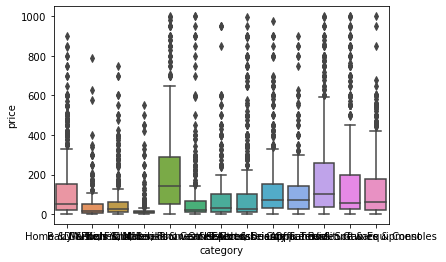

In [8]:
import seaborn as sns
sns.boxplot(x='category', y='price', data=facebook_df)

In [9]:
# facebook_df[['price']].sort_values(by=['price'], ascending=False)

In [10]:
# Create the model
product_X = facebook_df[['category']]
product_y = facebook_df['price']

product_X = pd.get_dummies(product_X, drop_first=True)

product_X

,category_Baby & Kids Stuff,"category_Clothes, Footwear & Accessories",category_Computers & Software,category_DIY Tools & Materials,category_Health & Beauty,category_Home & Garden,"category_Music, Films, Books & Games",category_Office Furniture & Equipment,category_Other Goods,"category_Phones, Mobile Phones & Telecoms","category_Sports, Leisure & Travel",category_Video Games & Consoles
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7151,0,0,0,0,0,0,0,0,0,0,0,1
7152,0,0,0,0,0,0,0,0,0,0,0,1
7153,0,0,0,0,0,0,0,0,0,0,0,1
7154,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
product_X_train, product_X_test, product_y_train, product_y_test = train_test_split(product_X, product_y, test_size=0.2, random_state=0)

regr = LinearRegression()
regr.fit(product_X_train, product_y_train)

product_y_pred = regr.predict(product_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(product_y_test, product_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(product_y_test, product_y_pred))


Coefficients: 
 [-60.32706033 -30.40027146  94.13766729 -37.26823331   8.34051918
  19.51812472 -79.99724316  66.22897467 -22.15939404 112.5764878
  30.47952086  33.74035235]
Mean squared error: 29537.75
Coefficient of determination: 0.08


In [12]:
merged_df = image_df.merge(facebook_df,
                           how='inner',
                           left_on='product_id',
                           right_on='id')

In [13]:
def export_df_to_csv(df):
    """
    Export the dataframe to a csv file.

    Args:
        df (pandas.DataFrame): The dataframe to export.
    """
    df.to_csv('data/merged_df.csv', index=False)

export_df_to_csv(merged_df)  

In [14]:
import torch
import random
import glob
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


class MarketPlace:
    def __init__(self, df: pd, column_to_index: str) -> None:
        self.df = df
        self.create_dict_of_categories(df, column_to_index)
        self.create_df_of_image_paths()
        self.numberise_categories(column_to_index)

    def create_dict_of_categories(self, df: pd, column_to_index: str) -> None:
        self.categories_dict = set(df[column_to_index])
        self.categories_dict = {k: v for v, k in enumerate(self.categories_dict)}

    def create_df_of_image_paths(self) -> None:
        self.image_paths = glob.glob('resized/*.jpg')
        self.image_paths = [x.split('/')[-1] for x in self.image_paths]
        self.image_paths = [x.split('.')[0] for x in self.image_paths]

    def numberise_categories(self, column_to_index) -> None:
        # replace the category column with the index of the category
        self.df[column_to_index] = self.df[column_to_index].map(self.categories_dict)
        self.image_df = pd.DataFrame({'image_path': self.image_paths})
        # merge the image_df with the df
        self.images_category_df = self.image_df.merge(self.df, how='inner', left_on='image_path', right_on='id_x')
        # drop all columns except the image_path and the category
        self.images_category_df = self.images_category_df[['image_path', column_to_index]]
        
    def prepare_image_category_datapoint(self, index: int) -> None:
        image = self.images_category_df['image_path'][index]
        image = Image.open('resized/' + image + '.jpg')
        image = np.array(image)
        image = torch.from_numpy(image)
        image = torch.flatten(image)
        category = self.images_category_df['category'][index]
        return (image, category)
     
# Init object and create dataset
fb_model = MarketPlace(merged_df, 'category')
complete_dataset = []
array_size = 49152
n = len(fb_model.images_category_df)
X = np.zeros((n, array_size))
y = np.zeros(n)


In [22]:
# create list of indexes to randomise
indexes = list(range(n))
random.shuffle(indexes)

for idx in indexes:
    complete_dataset.append(fb_model.prepare_image_category_datapoint(idx))
    
for idx in range(n):    
    features, label = complete_dataset[idx]  
    X[idx, :] = features
    y[idx] = label

In [23]:

#test_proportion of 3 means 1/3 so 33% test and 67% train
def test_split(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion) #should be int
    X_train = matrix[ratio:]
    X_test =  matrix[:ratio]
    y_train = target[ratio:]
    y_test =  target[:ratio]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = test_split(X, y, 5)

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)


/home/pete/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [18]:
predictions = model.predict(X_test)


In [19]:
from sklearn import metrics

score = model.score(X_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)


0.15746333045729077
[[16 13  9 17 11 14 21  7 20 23 10 10  6]
 [ 8 34  6 16 16  7 17  7 11 11  7 11 12]
 [ 7 10 30 12 11 13 30  3 26 15 16 10 13]
 [15  8 21 24  4 12 34  5 11 17 10  3  9]
 [ 4 13 21 12 30  4 19  4 16 11  7  9 12]
 [ 7  9 11 10  5 20 34  2 13 10 14  7 11]
 [ 7 17 28 22  9 15 73  3 34 19 24 20 22]
 [ 8 10  6 11 10  9 24  6  6  7  9  7 11]
 [ 9  9 14 19  4 18 41  3 31  6 15  6 19]
 [ 8 14 20 13  7 23 15  8 13 46  6 12 11]
 [ 5  8 11 11  8 13 20  4 19 13 17  7 12]
 [11 11  7  9  7 12 32  3 16 11 15 18  8]
 [12 16 12 12 10 12 31  5 16 18  6  9 20]]


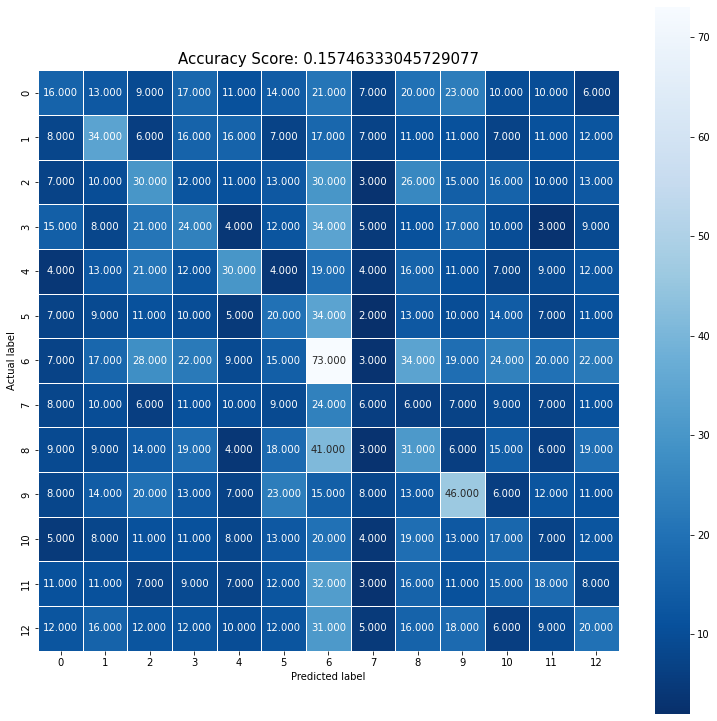

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [21]:
fb_model.categories_dict

{'Video Games & Consoles ': 0,
 'Clothes, Footwear & Accessories ': 1,
 'Health & Beauty ': 2,
 'Music, Films, Books & Games ': 3,
 'Phones, Mobile Phones & Telecoms ': 4,
 'Other Goods ': 5,
 'Home & Garden ': 6,
 'Baby & Kids Stuff ': 7,
 'Office Furniture & Equipment ': 8,
 'Computers & Software ': 9,
 'DIY Tools & Materials ': 10,
 'Sports, Leisure & Travel ': 11,
 'Appliances ': 12}